In [1]:
import numpy as np
from numpy import linalg as la
import math
import matplotlib.pyplot as plt
from sympy import *
import pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Import Data

In [2]:
from get_data import get_data
from adap_ppf import fit_vel_model, fit_ofc_model, ofc_ppf
import mat73
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
zInfo = mat73.loadmat('../data/Frank_InfoGathering_All_Data.mat')
starts = [1, 17, 29, 47, 62, 77, 100, 121, 140, 160, 180, 209, 228, 247, 266, 277, 296, 311, 331, 350, 371, 394, 414, 427, 433, 438] # mapping of neuron data to session

data-specific params
[rast, direction, regionNum, EyeX, EyeY] = get_data(zInfo, 10, starts[10], starts[11], False)

# with open("rast.pkl","wb") as f:
#     pickle.dump(rast, f)
# with open("direction.pkl","wb") as f:
#     pickle.dump(direction, f)
# with open("EyeX.pkl","wb") as f:
#     pickle.dump(EyeX, f)
# with open("EyeY.pkl","wb") as f:
#     pickle.dump(EyeY, f)

In [4]:
# with open("rast.pkl","rb") as f:
#     rast = pickle.load(f)
# with open("direction.pkl","rb") as f:
#     direction = pickle.load(f)
# with open("EyeX.pkl","rb") as f:
#     EyeX = pickle.load(f)
# with open("EyeY.pkl","rb") as f:
#     EyeY = pickle.load(f)

duration = rast.shape[2] - 200
ntrials = rast.shape[1]
c = rast.shape[0] #number of neurons in ensemble
step = 0.001

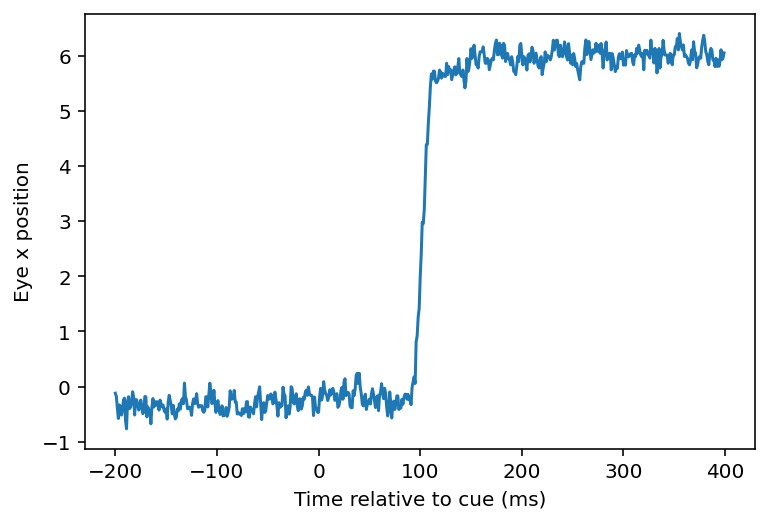

In [5]:
plt.figure(figsize=(6,4))
plt.plot(range(-200,400), EyeX[3]); plt.ylabel("Eye x position"); plt.xlabel("Time relative to cue (ms)");

### Fit Optimal Feedback Control Model

In [6]:
# Set forward model parameters

# maximum likelihood estimation for velocity state transition model
Av = np.zeros((2,2))  # kinematics evolution matrix
Wv = np.zeros((2,2))  # white noise

# would normally be done with one large section of continuous data
for i in range(0, ntrials):
    av, wv = fit_vel_model(EyeX[i,285:311],EyeY[i,285:311]) #only using portions with nonzero velocity
    Av += av
    Wv += wv

Av = Av/ntrials; Wv = Wv/ntrials

In [7]:
A, B, w, L = fit_ofc_model(Av, Wv, step, .020)

In [8]:
# initialize target values
x_targ = np.zeros((4,600))
for i in range(290,600):
    x_targ[0,i] = 6.25
    x_targ[1,i] = -6.25

In [9]:
x_int = np.zeros((4,int(600)))
for t in range(1,600):
    x_int[:,t] = (A-B@L)@(x_int[:,t-1].reshape((4,1)))[:,0] + (B@L@x_targ[:,t].reshape((4,1)))[:,0]

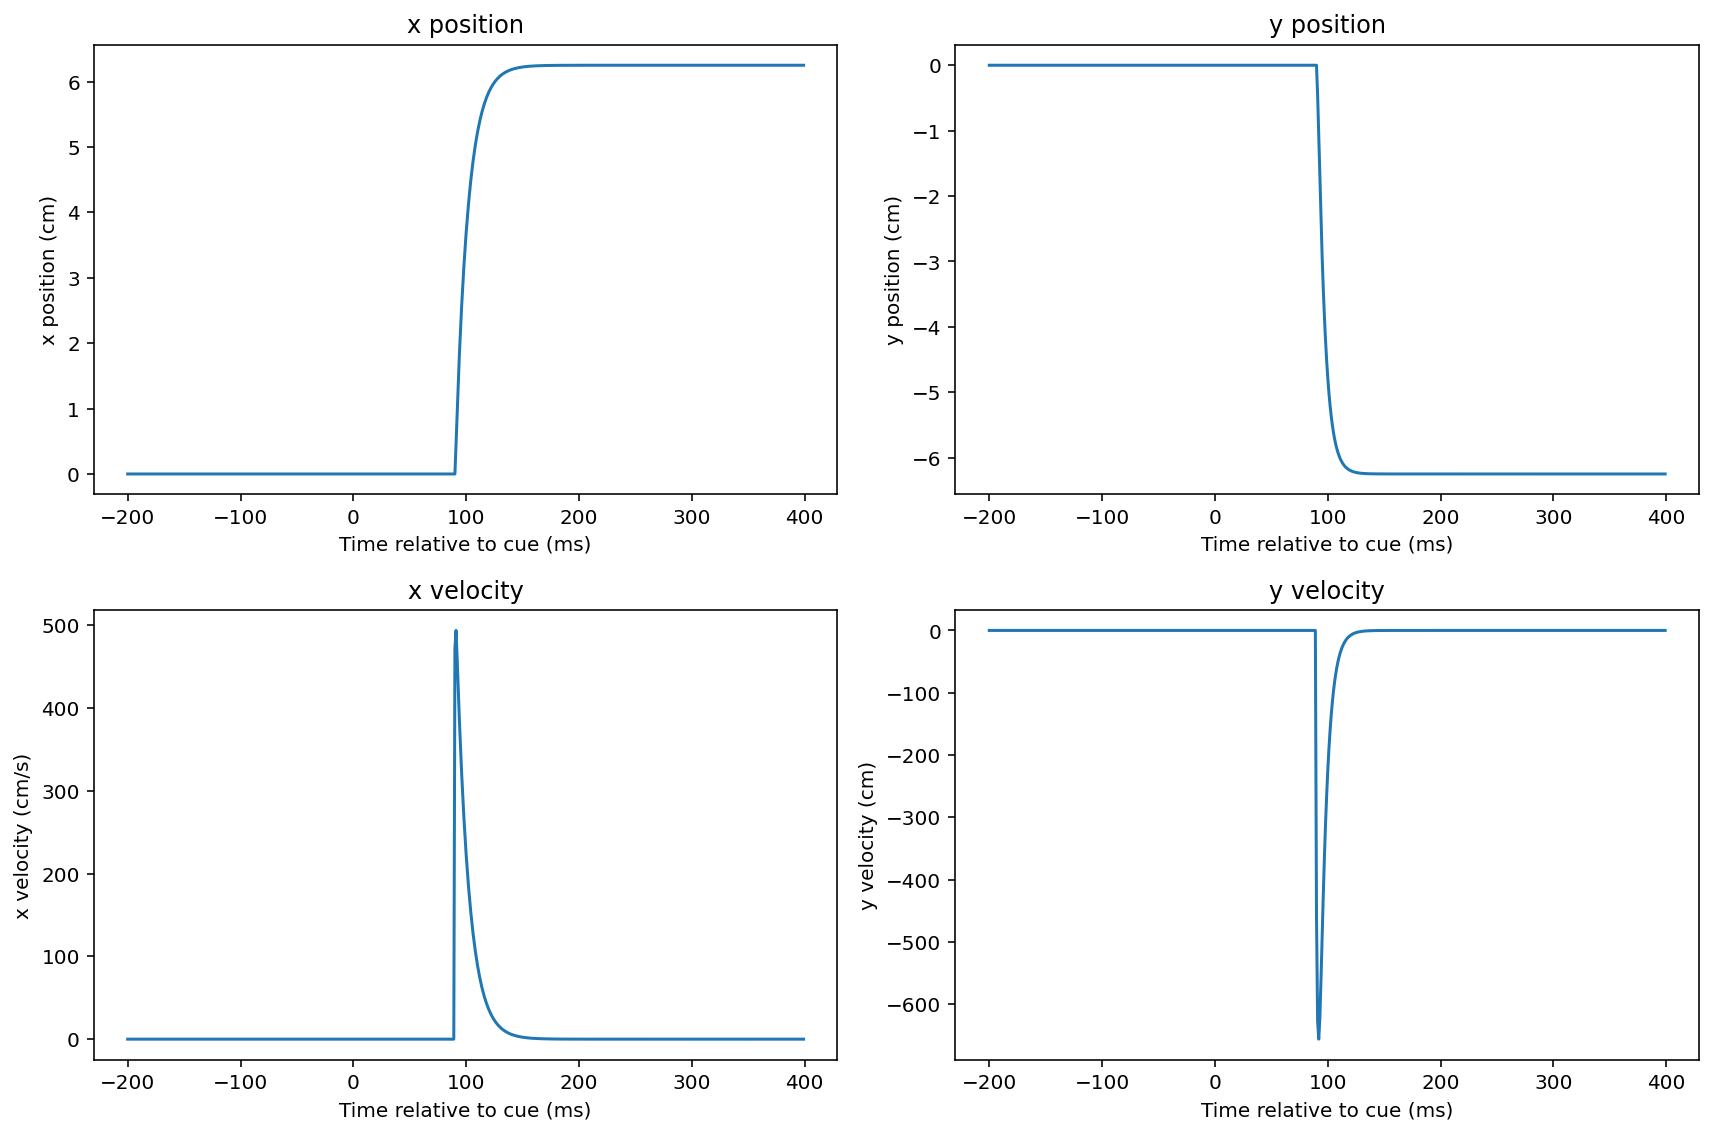

In [10]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(range(-200,400),x_int[0,:]); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("x position (cm)"); plt.title("x position")

plt.subplot(2,2,2)
plt.plot(range(-200,400),x_int[1,:]); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("y position (cm)"); plt.title("y position")

plt.subplot(2,2,3)
plt.plot(range(-200,400),x_int[2,:]); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("x velocity (cm/s)"); plt.title("x velocity")

plt.subplot(2,2,4)
plt.plot(range(-200,400),x_int[3,:]); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("y velocity (cm)"); plt.title("y velocity");

plt.tight_layout()

In [11]:
dX = EyeX[0,:]; dY = EyeY[0,:];
vX = np.diff(dX,1); vY = np.diff(dY,1);

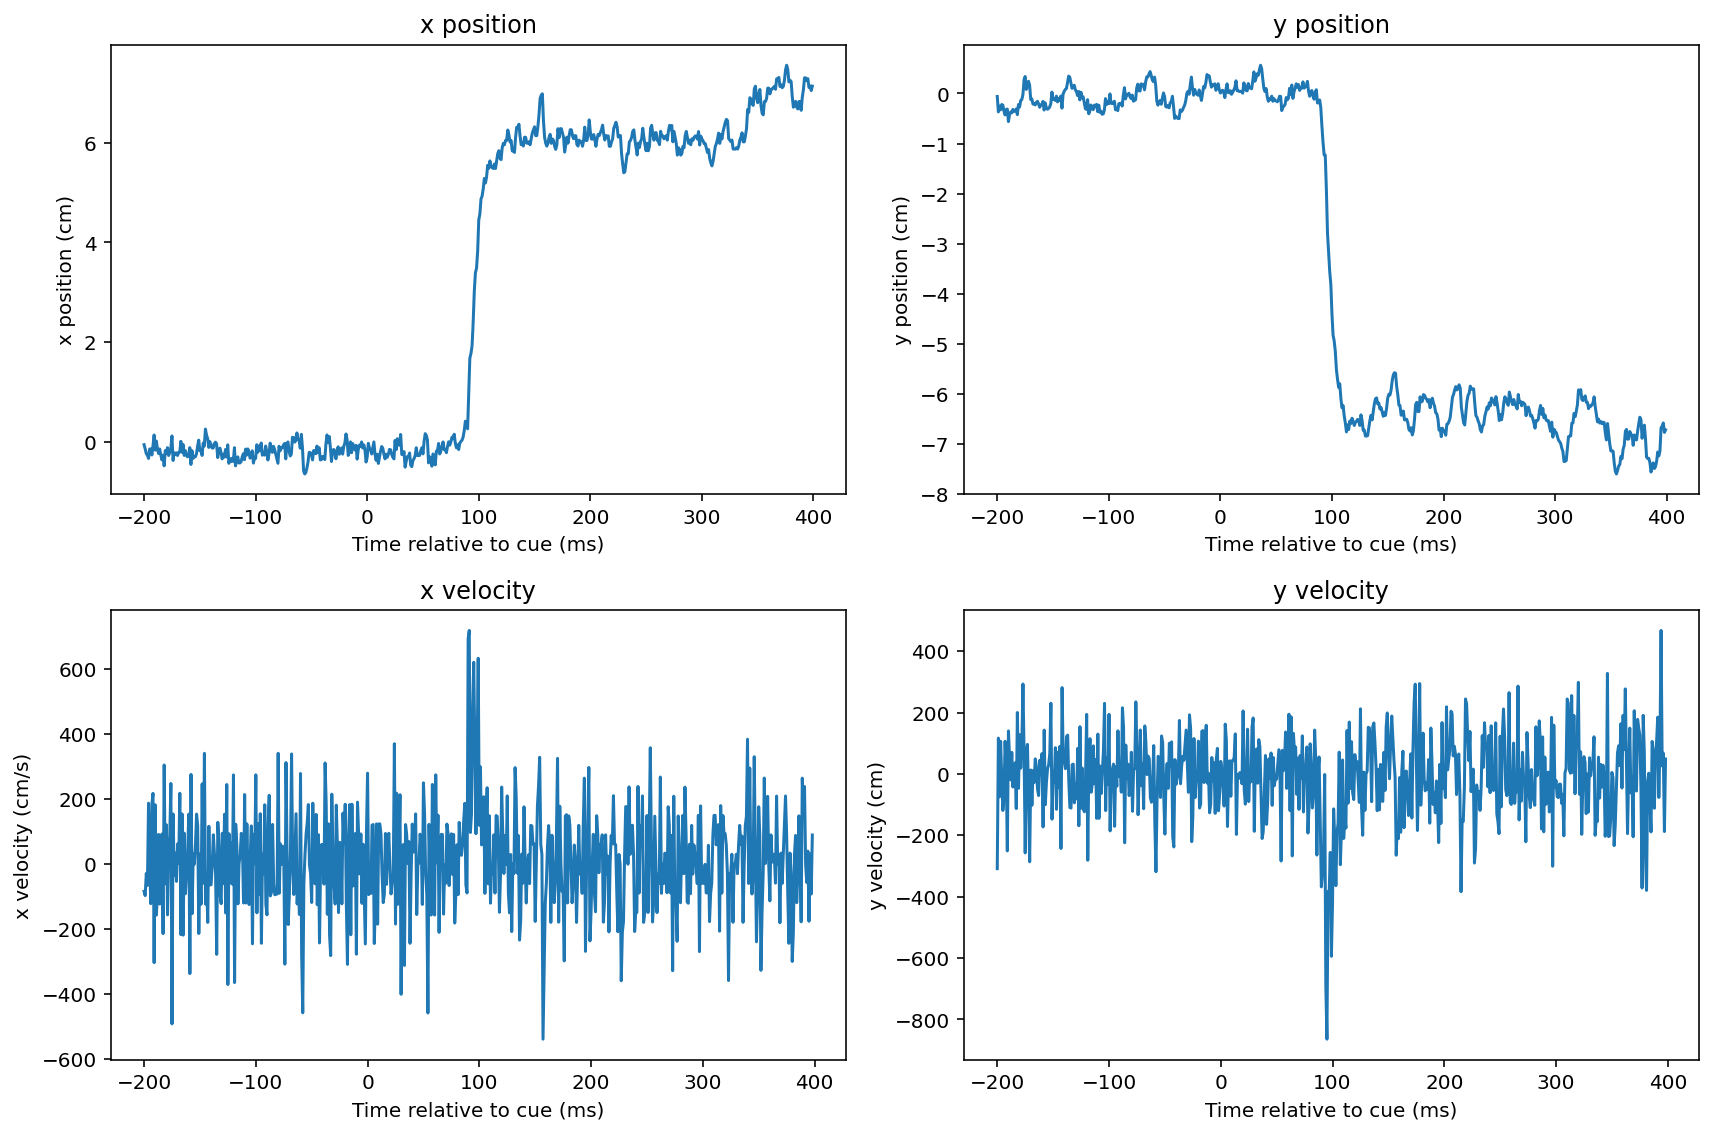

In [12]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(range(-200,400),dX); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("x position (cm)"); plt.title("x position")

plt.subplot(2,2,2)
plt.plot(range(-200,400),dY); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("y position (cm)"); plt.title("y position")

plt.subplot(2,2,3)
plt.plot(range(-200,399),vX*1000); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("x velocity (cm/s)"); plt.title("x velocity")

plt.subplot(2,2,4)
plt.plot(range(-200,399),vY*1000); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("y velocity (cm)"); plt.title("y velocity");

plt.tight_layout()

### Decoding

In [13]:
def decode(duration, step, w, rast, direction, A, B, L, tr):
    spike = rast[:,tr,200:]
    dirc = direction[tr]
    x_targ = np.zeros((1,4))
    
    if dirc % 2 == 1:
        x_targ[0,1] = 6.25
    else:
        x_targ[0,1] = -6.25

    if dirc > 2: 
        x_targ[0,0] = 6.25
    else:
        x_targ[0,0] = -6.25
        
    # learning rate, set based on relative scale of parameters
    Q = np.zeros((3,3))
    Q[0,0] = 10**-6
    Q[1,1] = 10**-4
    Q[2,2] = 10**-4
    
    beta, alpha_1, alpha_2, x_1, x_2, v_1, v_2 = symbols('beta alpha_1 alpha_2 x_1, x_2 v_1 v_2', real=True)
    expr = exp(beta + alpha_1*v_1 + alpha_2*v_2)
    
    param_sym = [beta, alpha_1, alpha_2]
    target_sym = [x_1, x_2, v_1, v_2]
    init_params = np.zeros((29, 3))
    x, param, W = ofc_ppf(duration, step, expr, param_sym, target_sym, init_params, Q, w, A, B, L, x_targ, spike)
    return x, param, W

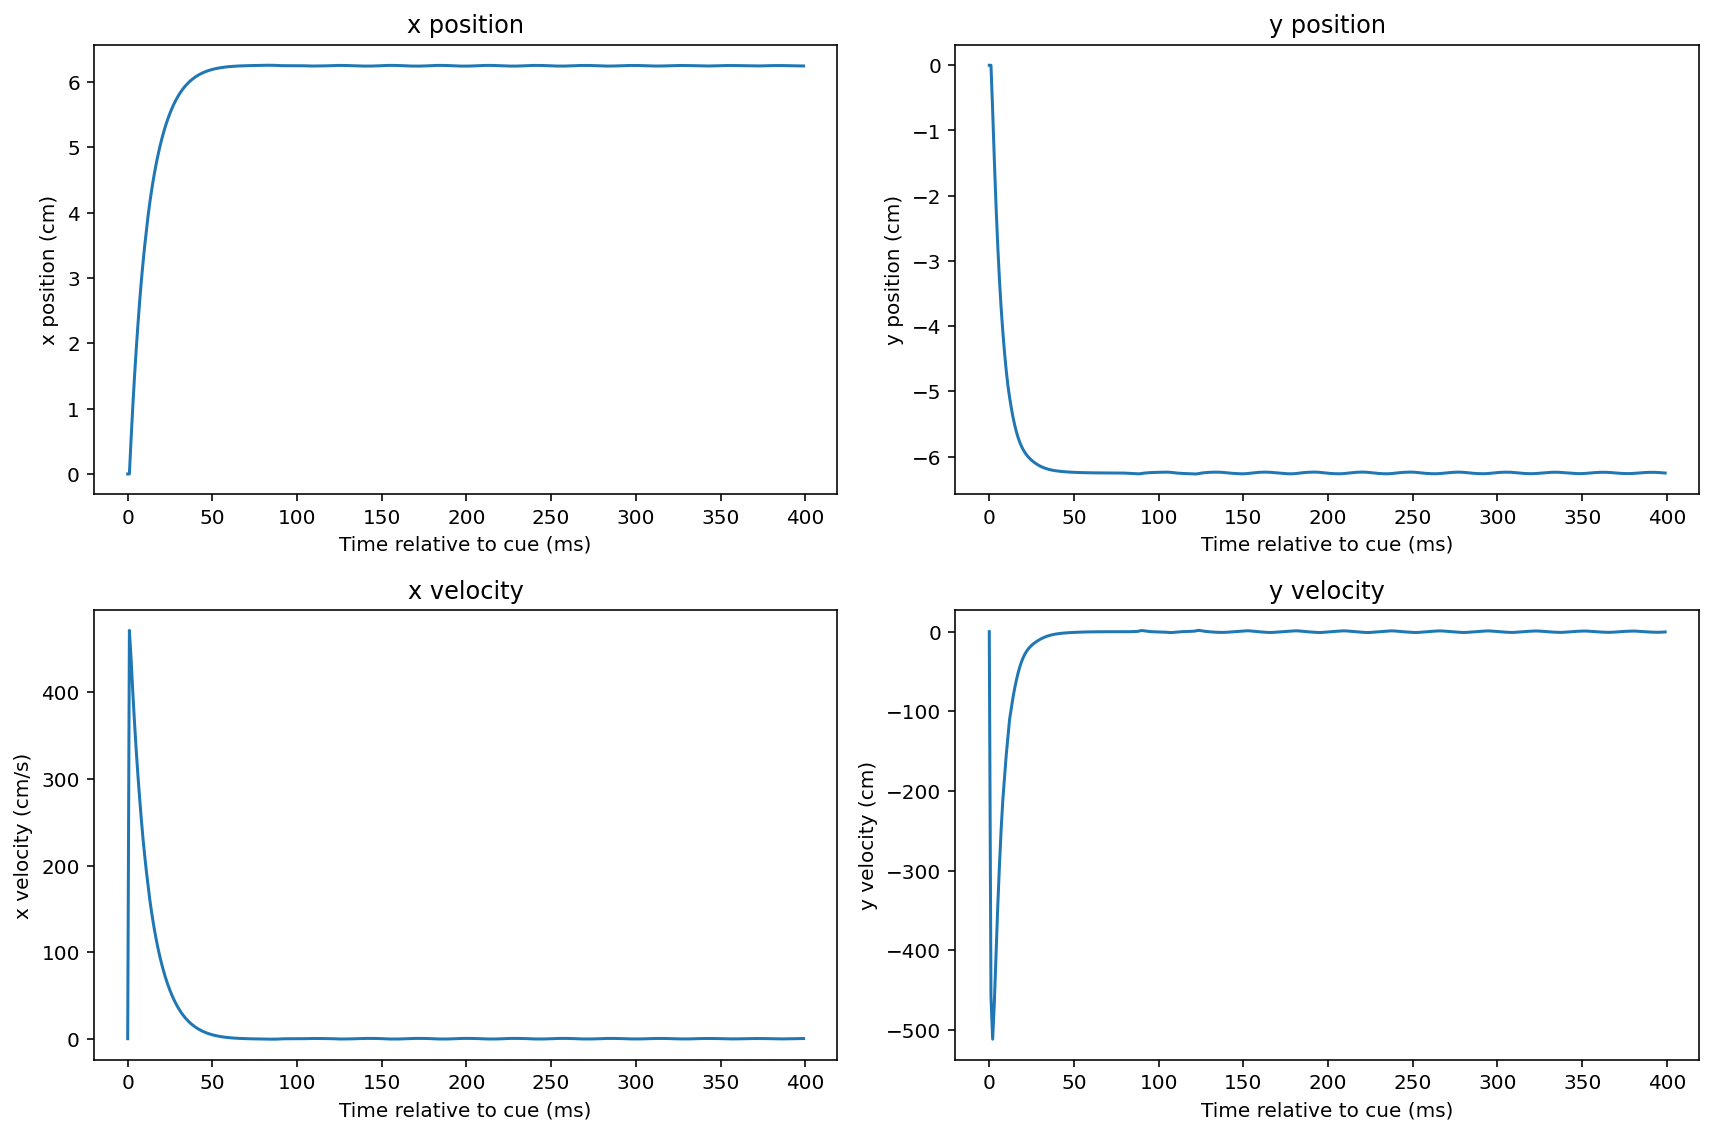

In [14]:
x, param, W = decode(duration, step, w, rast, direction, A, B, L, 0)

x = x.T
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(range(0,400),x[0,:]); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("x position (cm)"); plt.title("x position")

plt.subplot(2,2,2)
plt.plot(range(0,400),x[1,:]); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("y position (cm)"); plt.title("y position")

plt.subplot(2,2,3)
plt.plot(range(0,400),x[2,:]); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("x velocity (cm/s)"); plt.title("x velocity")

plt.subplot(2,2,4)
plt.plot(range(0,400),x[3,:]); plt.xlabel("Time relative to cue (ms)");
plt.ylabel("y velocity (cm)"); plt.title("y velocity");

plt.tight_layout()